In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [9]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [42]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [48]:
batch_size = 512
epochs = 100
learning_rate = 1e-3

In [44]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [45]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape=784).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

In [49]:

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/100, recon loss = 0.03942671
epoch : 2/100, recon loss = 0.03794590
epoch : 3/100, recon loss = 0.03586266
epoch : 4/100, recon loss = 0.03348198
epoch : 5/100, recon loss = 0.03134171
epoch : 6/100, recon loss = 0.02934045
epoch : 7/100, recon loss = 0.02732071
epoch : 8/100, recon loss = 0.02587734
epoch : 9/100, recon loss = 0.02467648
epoch : 10/100, recon loss = 0.02379998
epoch : 11/100, recon loss = 0.02284766
epoch : 12/100, recon loss = 0.02166009
epoch : 13/100, recon loss = 0.02069024
epoch : 14/100, recon loss = 0.01997665
epoch : 15/100, recon loss = 0.01933771
epoch : 16/100, recon loss = 0.01870207
epoch : 17/100, recon loss = 0.01810561
epoch : 18/100, recon loss = 0.01755528
epoch : 19/100, recon loss = 0.01708764
epoch : 20/100, recon loss = 0.01663979
epoch : 21/100, recon loss = 0.01599353
epoch : 22/100, recon loss = 0.01552004
epoch : 23/100, recon loss = 0.01510501
epoch : 24/100, recon loss = 0.01472413
epoch : 25/100, recon loss = 0.01435679
epoch : 2

In [51]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model(test_examples)
        break

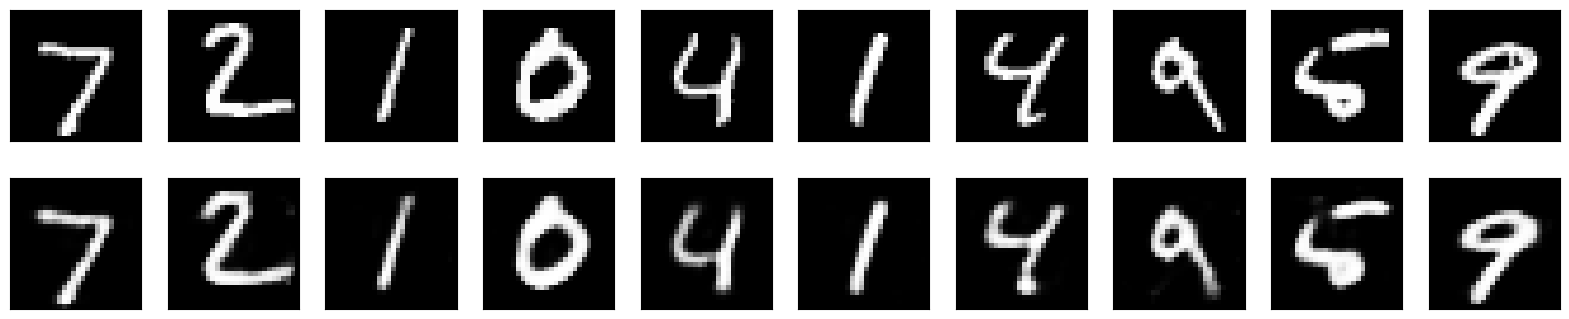

In [53]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Variational Autoencoders

In [22]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim=200):
        super().__init__()
        self.img_2hid = nn.Linear(input_dim, h_dim)

        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        new_h = F.relu(self.z_2hid(z))
        x = torch.sigmoid(self.hid_2img(new_h))
        return x

    def forward(self, x):
        mu, sigma = self.encode(x)

        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        x = self.decode(z_reparametrized)
        return x, mu, sigma


In [24]:
device = 'cpu'
INPUT_DIM = 784
Z_DIM = 20
H_DIM = 200
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 3e-4


In [25]:
import torchvision.datasets as datasets  
import torchvision.transforms as transforms
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
import torch.nn.functional as F

In [26]:
from torch.utils.data import DataLoader  
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
def train(num_epochs, model, optimizer, loss_fn):
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader))
        for i, (x, y) in loop:
            x = x.to(device).view(-1, INPUT_DIM)
            x_reconst, mu, sigma = model(x)

            reconst_loss = loss_fn(x_reconst, x)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

In [28]:
from tqdm import tqdm
model = VariationalAutoEncoder(INPUT_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

train(NUM_EPOCHS, model, optimizer, loss_fn)

1875it [00:08, 216.02it/s, loss=5.57e+3]
1875it [00:08, 216.93it/s, loss=4.78e+3]
1875it [00:08, 214.09it/s, loss=4.55e+3]
1875it [00:08, 215.53it/s, loss=4.15e+3]
1875it [00:08, 209.98it/s, loss=4.26e+3]
1875it [00:08, 211.59it/s, loss=4.06e+3]
1875it [00:09, 205.79it/s, loss=4.01e+3]
1875it [00:09, 203.54it/s, loss=4.37e+3]
1875it [00:09, 207.12it/s, loss=4.26e+3]
1875it [00:09, 205.78it/s, loss=4.09e+3]


In [70]:
from torchvision.utils import save_image
def inference(digit, num_examples=1):
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=214),
            transforms.ToTensor()
        ])
        out = [transform(x_) for x_ in out]
        save_image(out, f"generated_{digit}_ex{example}.png")
        

inference(2,5)

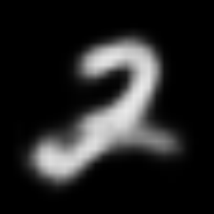

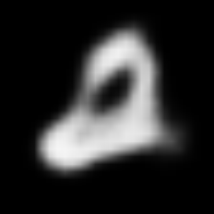

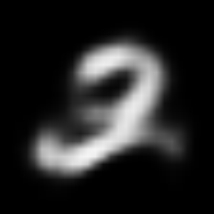

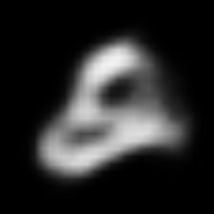

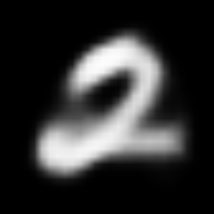

In [71]:
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import glob
from PIL import Image
for image_path in glob.glob("*.png"):
     display.display(Image.open(str(image_path)))